In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
import os
import sys

print("✓ Librerie importate")
print(f"PyTorch version: {torch.__version__}")
print(f"Device disponibile: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")

✓ Librerie importate
PyTorch version: 2.7.1+cu118
Device disponibile: cuda


## 2. DATA LOADING

In [4]:
# Carica il dataset NILM ready
df = pd.read_parquet("nilm_ready_dataset.parquet")
df['Time'] = pd.to_datetime(df['Time'])
df = df.sort_values('Time').reset_index(drop=True)

print(f"Dataset NILM caricato: {df.shape[0]} righe, {df.shape[1]} colonne")
print(f"\nColonne disponibili:")
print(df.columns.tolist())

# Definisci INPUT e TARGET
# Input: Aggregate (consumo totale edificio)
# Target: seleziona l'appliance da disaggregare
TARGET_APPLIANCE = 'HeatPump'  # Puoi cambiare con: 'Oven', 'Dishwasher', 'WashingMachine', ecc.

Building = df[['Time', 'Aggregate']].copy()
Building.columns = ['_time', '_value']

Oven = df[['Time', TARGET_APPLIANCE]].copy()
Oven.columns = ['_time', '_value']

print(f"\n✓ Input (Aggregate): {Building.shape[0]} righe")
print(f"✓ Target ({TARGET_APPLIANCE}): {Oven.shape[0]} righe")
print(f"\nRange temporale: {df['Time'].min()} → {df['Time'].max()}")
df.head()

Dataset NILM caricato: 35040 righe, 14 colonne

Colonne disponibili:
['Time', 'Aggregate', 'RangeHood', 'Dryer', 'Stove', 'GarageCabinet', 'ChargingStation_Socket', 'Oven', 'RainwaterPump', 'SmappeeCharger', 'Dishwasher', 'HeatPump', 'HeatPump_Controller', 'WashingMachine']

✓ Input (Aggregate): 35040 righe
✓ Target (HeatPump): 35040 righe

Range temporale: 2024-10-20 02:15:00 → 2025-10-20 02:00:00


,Time,Aggregate,RangeHood,Dryer,Stove,GarageCabinet,ChargingStation_Socket,Oven,RainwaterPump,SmappeeCharger,Dishwasher,HeatPump,HeatPump_Controller,WashingMachine
0,2024-10-20 02:15:00,0.198563,0.000000,0.003,0.0,0.022450,0.0,0.0,0.0,0.003,0.0,0.004004,0.0,0.0
1,2024-10-20 02:30:00,0.228958,0.000002,0.003,0.0,0.024443,0.0,0.0,0.0,0.003,0.0,0.004002,0.0,0.0
2,2024-10-20 02:45:00,0.216411,0.000000,0.003,0.0,0.103922,0.0,0.0,0.0,0.003,0.0,0.004003,0.0,0.0
3,2024-10-20 03:00:00,0.170043,0.000000,0.003,0.0,0.019961,0.0,0.0,0.0,0.003,0.0,0.004001,0.0,0.0
4,2024-10-20 03:15:00,0.180233,0.000000,0.003,0.0,0.019991,0.0,0.0,0.0,0.003,0.0,0.004002,0.0,0.0


## 3. EXPLORATORY DATA ANALYSIS

In [5]:
# Analizza i dati
time_diff = Building['_time'].diff()
total_duration = Building['_time'].max() - Building['_time'].min()

print("=== DATASET NILM ===")
print(f"Intervallo minimo: {time_diff.min()}")
print(f"Intervallo massimo: {time_diff.max()}")
print(f"Intervallo medio: {time_diff.mean()}")
print(f"Durata totale: {total_duration.days} giorni")
print(f"Righe per giorno: {len(Building) / max(total_duration.days, 1):.0f}")

# Calcola sequenze per 1 giorno (96 punti = 24h * 4 punti/ora per dati ogni 15 min)
rows_per_day = 96  # 15 minuti * 96 = 24 ore
window_size = rows_per_day
print(f"\nWindow size scelto: {window_size} (sequenza di ~1 giorno con dati ogni 15 min)")

=== DATASET NILM ===
Intervallo minimo: 0 days 00:15:00
Intervallo massimo: 0 days 00:15:00
Intervallo medio: 0 days 00:15:00
Durata totale: 364 giorni
Righe per giorno: 96

Window size scelto: 96 (sequenza di ~1 giorno con dati ogni 15 min)


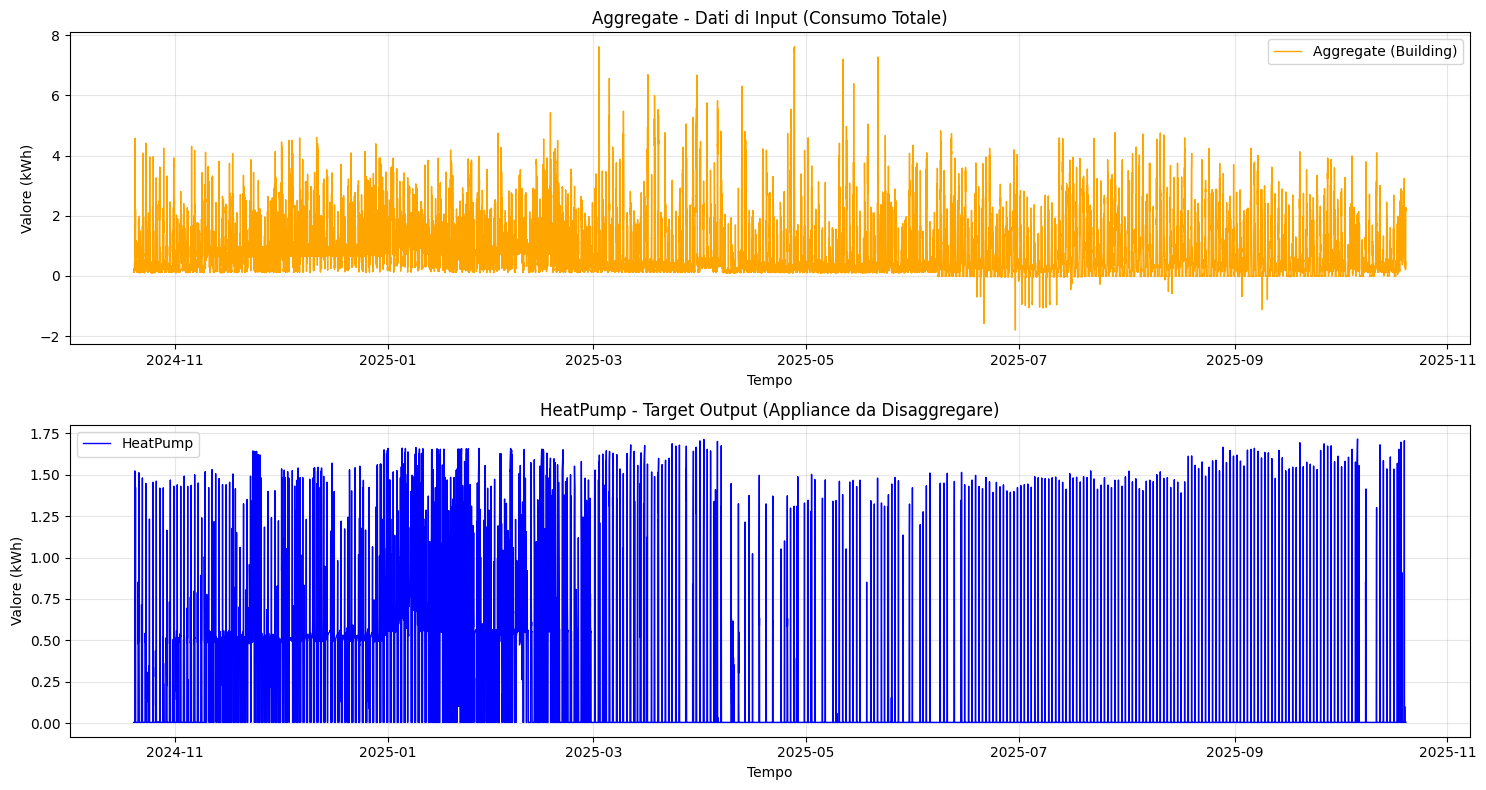

In [6]:
# Visualizza le timeline complete
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

axes[0].plot(Building['_time'], Building['_value'], linewidth=1, color='orange', label='Aggregate (Building)')
axes[0].set_title('Aggregate - Dati di Input (Consumo Totale)')
axes[0].set_xlabel('Tempo')
axes[0].set_ylabel('Valore (kWh)')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

axes[1].plot(Oven['_time'], Oven['_value'], linewidth=1, color='blue', label=f'{TARGET_APPLIANCE}')
axes[1].set_title(f'{TARGET_APPLIANCE} - Target Output (Appliance da Disaggregare)')
axes[1].set_xlabel('Tempo')
axes[1].set_ylabel('Valore (kWh)')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

## 4. DATA NORMALIZATION & SEQUENCE CREATION

In [7]:
# Normalizzazione dei dati
input_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit degli scaler sui dati completi
Building_values = Building[['_value']].values
Oven_values = Oven[['_value']].values

input_scaler.fit(Building_values)
target_scaler.fit(Oven_values)

# Normalizza i dati
Building_normalized = input_scaler.transform(Building_values)
Oven_normalized = target_scaler.transform(Oven_values)

print(f"✓ Dati normalizzati")
print(f"  Building: min={Building_normalized.min():.4f}, max={Building_normalized.max():.4f}")
print(f"  Oven: min={Oven_normalized.min():.4f}, max={Oven_normalized.max():.4f}")

✓ Dati normalizzati
  Building: min=0.0000, max=1.0000
  Oven: min=0.0000, max=1.0000


In [8]:
def create_sequences(input_data, target_data, seq_length, step=1):
    """
    Crea sequenze per il modello CNN Seq2Seq
    Input: Building (input_data)
    Target: Oven (target_data)
    """
    input_sequences = []
    target_sequences = []
    timestamps = []

    max_idx = min(len(input_data), len(target_data)) - seq_length

    for i in range(0, max_idx, step):
        input_seq = input_data[i:i+seq_length]
        target_seq = target_data[i:i+seq_length]
        
        input_sequences.append(input_seq)
        target_sequences.append(target_seq)
        timestamps.append(i)

    return input_sequences, target_sequences, timestamps

print("✓ Funzione create_sequences definita")

✓ Funzione create_sequences definita


In [9]:
# Train/Test split TEMPORALE (80% train, 20% test)
# IMPORTANTE: split sui dati grezzi PRIMA di creare le sequenze per evitare data leakage

train_ratio = 0.8
split_idx = int(len(Building_normalized) * train_ratio)

# Split dei dati normalizzati
Building_train = Building_normalized[:split_idx]
Building_test = Building_normalized[split_idx:]
Oven_train = Oven_normalized[:split_idx]
Oven_test = Oven_normalized[split_idx:]

print(f"✓ Train/Test Split temporale:")
print(f"  Training: {len(Building_train):,} punti ({train_ratio*100:.0f}%)")
print(f"  Test: {len(Building_test):,} punti ({(1-train_ratio)*100:.0f}%)")

# Crea le sequenze SEPARATE per train e test
sequence_step = 1

print(f"\nCreazione sequenze con window_size={window_size}, step={sequence_step}...")

# Sequenze di TRAINING
seq_building_train, seq_oven_train, timestamps_train = create_sequences(
    Building_train, Oven_train, 
    seq_length=window_size,
    step=sequence_step
)

# Sequenze di TEST
seq_building_test, seq_oven_test, timestamps_test = create_sequences(
    Building_test, Oven_test, 
    seq_length=window_size,
    step=sequence_step
)

print(f"\n✓ Sequenze TRAINING: {len(seq_building_train)}")
print(f"✓ Sequenze TEST: {len(seq_building_test)}")
print(f"✓ Dimensione sequenza: {seq_building_train[0].shape}")
print(f"\n⚠️ Train e Test sono COMPLETAMENTE SEPARATI temporalmente!")

✓ Train/Test Split temporale:
  Training: 28,032 punti (80%)
  Test: 7,008 punti (20%)

Creazione sequenze con window_size=96, step=1...

✓ Sequenze TRAINING: 27936
✓ Sequenze TEST: 6912
✓ Dimensione sequenza: (96, 1)

⚠️ Train e Test sono COMPLETAMENTE SEPARATI temporalmente!


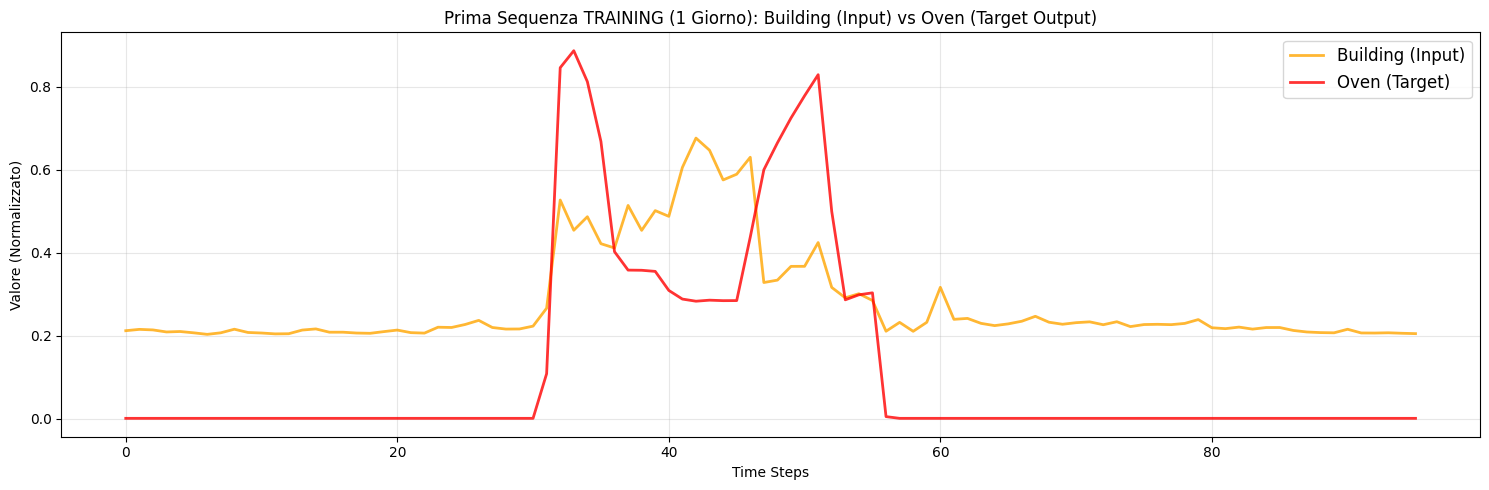

In [10]:
# Visualizza il confronto della prima sequenza di TRAINING (normalizzata)
plt.figure(figsize=(15, 5))
plt.plot(range(window_size), seq_building_train[0].flatten(), linewidth=2, color='orange', label='Building (Input)', alpha=0.8)
plt.plot(range(window_size), seq_oven_train[0].flatten(), linewidth=2, color='red', label='Oven (Target)', alpha=0.8)
plt.xlabel('Time Steps')
plt.ylabel('Valore (Normalizzato)')
plt.title('Prima Sequenza TRAINING (1 Giorno): Building (Input) vs Oven (Target Output)')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. MODEL DEFINITION - CNN Seq2Seq

In [ ]:
# Modello CNN Seq2Seq SEMPLIFICATO per NILM

class CNNSeq2Seq(nn.Module):
    """
    CNN Seq2Seq semplificato per disaggregazione energetica.
    Architettura più leggera con focus su catturare i picchi.
    """
    def __init__(self, input_size=1, hidden_channels=64, num_layers=3):
        super(CNNSeq2Seq, self).__init__()
        
        # Encoder: estrae features dall'input aggregato
        encoder_layers = []
        in_ch = input_size
        for i in range(num_layers):
            out_ch = hidden_channels * (2 ** i)
            encoder_layers.extend([
                nn.Conv1d(in_ch, out_ch, kernel_size=5, padding=2),
                nn.BatchNorm1d(out_ch),
                nn.LeakyReLU(0.2),
                nn.Dropout(0.1)
            ])
            in_ch = out_ch
        self.encoder = nn.Sequential(*encoder_layers)
        
        # Bottleneck
        self.bottleneck_ch = hidden_channels * (2 ** (num_layers - 1))
        
        # Decoder: ricostruisce il segnale dell'appliance
        decoder_layers = []
        in_ch = self.bottleneck_ch
        for i in range(num_layers - 1, -1, -1):
            out_ch = hidden_channels * (2 ** i) if i > 0 else hidden_channels
            decoder_layers.extend([
                nn.Conv1d(in_ch, out_ch, kernel_size=5, padding=2),
                nn.BatchNorm1d(out_ch),
                nn.LeakyReLU(0.2)
            ])
            in_ch = out_ch
        self.decoder = nn.Sequential(*decoder_layers)
        
        # Output layer - usa Sigmoid per output normalizzato [0,1]
        self.output_layer = nn.Sequential(
            nn.Conv1d(hidden_channels, 1, kernel_size=1),
            nn.Sigmoid()  # Forza output tra 0 e 1
        )
        
    def forward(self, x):
        # x: (batch, seq_len, 1) -> (batch, 1, seq_len)
        x = x.transpose(1, 2)
        
        # Encoder
        encoded = self.encoder(x)
        
        # Decoder
        decoded = self.decoder(encoded)
        
        # Output
        output = self.output_layer(decoded)
        
        # (batch, 1, seq_len) -> (batch, seq_len, 1)
        return output.transpose(1, 2)

print("✓ Modello CNN Seq2Seq SEMPLIFICATO definito")
print("  - Architettura più leggera")
print("  - Sigmoid output per valori [0,1]")
print("  - LeakyReLU per gradient flow")

✓ Modello CNN Seq2Seq definito
  - Encoder-Decoder architecture
  - Residual blocks con skip connections
  - Multi-scale convolutions
  - Channel attention


## 6. DATA PREPARATION FOR TRAINING

In [12]:
class EnergyDataset(Dataset):
    def __init__(self, input_sequences, target_sequences):
        self.input_sequences = [torch.FloatTensor(seq) for seq in input_sequences]
        self.target_sequences = [torch.FloatTensor(seq) for seq in target_sequences]
    
    def __len__(self):
        return len(self.input_sequences)
    
    def __getitem__(self, idx):
        return self.input_sequences[idx], self.target_sequences[idx]

print("✓ EnergyDataset definito")

✓ EnergyDataset definito


## 7. TRAINING

In [ ]:
# ===== CONFIGURAZIONE E TRAINING =====

batch_size = 32
hidden_channels = 64
num_layers = 3
num_epochs = 100
learning_rate = 0.001

# Usa TUTTE le sequenze (no sampling) per catturare meglio i picchi rari
train_dataset = EnergyDataset(seq_building_train, seq_oven_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

print(f"Sequenze TRAINING: {len(seq_building_train):,}")
print(f"Sequenze TEST: {len(seq_building_test):,}")
print(f"Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")

# Setup modello
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNSeq2Seq(input_size=1, hidden_channels=hidden_channels, num_layers=num_layers).to(device)
print(f"Parametri: {sum(p.numel() for p in model.parameters()):,}")

# === LOSS FUNCTION: Focal-style per dati sbilanciati ===
class NILMLoss(nn.Module):
    """
    Loss per NILM con dati sbilanciati (molti zeri, pochi picchi).
    Combina MSE con penalità pesata per sotto-predizioni sui picchi.
    """
    def __init__(self, gamma=2.0, peak_weight=10.0):
        super(NILMLoss, self).__init__()
        self.gamma = gamma  # Esponente per focal weighting
        self.peak_weight = peak_weight  # Peso extra per i picchi
        
    def forward(self, pred, target):
        # MSE base
        mse = (pred - target) ** 2
        
        # Focal weighting: pesa di più gli errori dove il target è alto
        # target alto -> weight alto
        focal_weight = (target ** self.gamma) * self.peak_weight + 1.0
        
        # Loss pesata
        weighted_mse = (mse * focal_weight).mean()
        
        # Penalità aggiuntiva per sotto-predizioni (quando target > pred)
        under_pred = torch.clamp(target - pred, min=0)
        under_pred_penalty = (under_pred ** 2 * focal_weight).mean()
        
        return weighted_mse + under_pred_penalty

criterion = NILMLoss(gamma=2.0, peak_weight=10.0)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5)

print("✓ NILMLoss configurata (focal-style per picchi)")

CONFIGURAZIONE CNN Seq2Seq
Sequenze TRAINING: 9,312 (sample_step=3)
Sequenze TEST: 6,912 (non usate nel training!)
Batch size: 64 | Batches/epoca: 146
Modello: CNN con 4 layer, 128 canali
Learning rate: 0.0005
Device: GPU 🚀

✓ Modello CNN: 1,056,385 parametri
✓ Loss combinata (MSE + MAE + Penalità Asimmetrica) configurata
   → Penalizza fortemente sotto-predizioni quando il target è alto
✓ AdamW optimizer e Cosine annealing scheduler attivi


In [ ]:
import time

# Training loop
train_losses = []
best_loss = float('inf')
patience, patience_counter = 15, 0

print(f"🚀 Training ({num_epochs} epoche, early stopping patience={patience})\n")

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    start = time.time()
    
    for inp, tgt in train_loader:
        inp, tgt = inp.to(device), tgt.to(device)
        
        pred = model(inp)
        loss = criterion(pred, tgt)
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    scheduler.step(avg_loss)
    
    # Early stopping
    if avg_loss < best_loss:
        best_loss = avg_loss
        patience_counter = 0
        best_model_state = model.state_dict().copy()
    else:
        patience_counter += 1
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1:3d} | Loss: {avg_loss:.6f} | LR: {optimizer.param_groups[0]['lr']:.6f} | {time.time()-start:.1f}s")
    
    if patience_counter >= patience:
        print(f"\n⚠️ Early stopping at epoch {epoch+1}")
        break

model.load_state_dict(best_model_state)
print(f"\n✓ Training completato! Best loss: {best_loss:.6f}")


🚀 Inizio training CNN Seq2Seq (150 epoche)...
   Early stopping: patience=20

Epoch   1/150 | Loss: 0.139250 | LR: 0.000499 | Time: 2.0s
Epoch  10/150 | Loss: 0.020034 | LR: 0.000375 | Time: 1.6s
Epoch  20/150 | Loss: 0.010429 | LR: 0.000125 | Time: 1.6s
Epoch  30/150 | Loss: 0.007537 | LR: 0.000500 | Time: 1.6s
Epoch  40/150 | Loss: 0.010978 | LR: 0.000467 | Time: 1.6s
Epoch  50/150 | Loss: 0.007945 | LR: 0.000375 | Time: 1.6s
Epoch  60/150 | Loss: 0.005062 | LR: 0.000250 | Time: 1.7s
Epoch  70/150 | Loss: 0.003979 | LR: 0.000125 | Time: 1.6s
Epoch  80/150 | Loss: 0.003179 | LR: 0.000033 | Time: 1.7s
Epoch  90/150 | Loss: 0.002984 | LR: 0.000500 | Time: 1.6s
Epoch 100/150 | Loss: 0.005246 | LR: 0.000491 | Time: 1.6s
Epoch 110/150 | Loss: 0.005567 | LR: 0.000467 | Time: 1.6s

⚠️ Early stopping at epoch 110

✓ Training completato! Best loss: 0.002984


## 8. RESULTS & VISUALIZATION

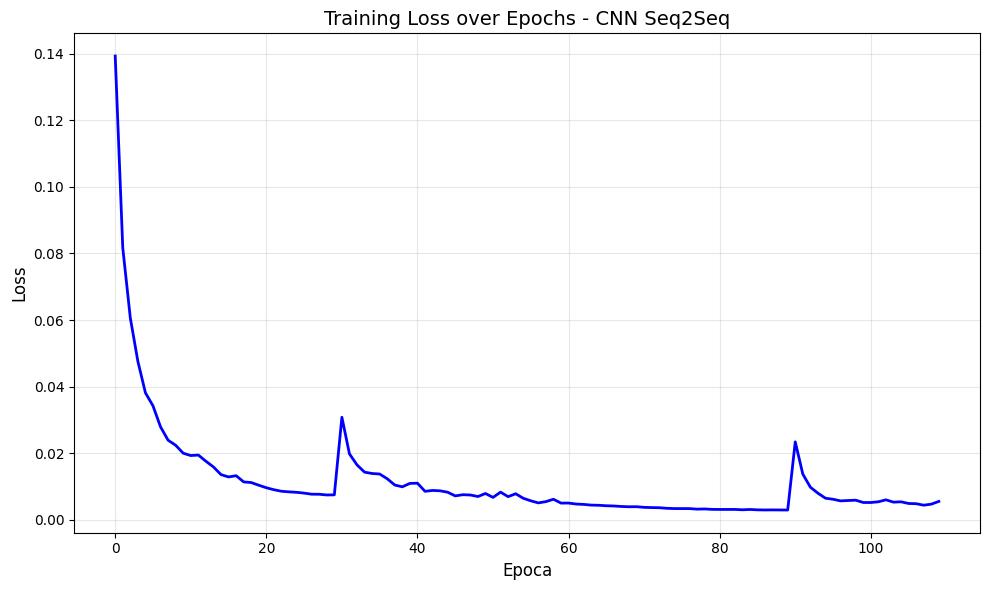

Loss iniziale: 0.139250
Loss finale: 0.005567
Best loss: 0.002984


In [ ]:
# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(train_losses)
plt.xlabel('Epoca')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True, alpha=0.3)
plt.show()
print(f"Loss: {train_losses[0]:.4f} → {train_losses[-1]:.4f} (best: {best_loss:.4f})")

In [32]:
# Salva il modello
model_path = f"seq2seq_cnn_{TARGET_APPLIANCE.lower()}_model.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'hyperparameters': {
        'hidden_channels': hidden_channels,
        'num_layers': num_layers,
        'window_size': window_size,
        'target_appliance': TARGET_APPLIANCE
    },
    'train_losses': train_losses,
    'input_scaler': input_scaler,
    'target_scaler': target_scaler
}, model_path)
print(f"✓ Modello CNN salvato: {model_path}")

✓ Modello CNN salvato: seq2seq_cnn_heatpump_model.pth


## 9. INFERENCE & EVALUATION

In [35]:
# Test su una sequenza del TEST SET (mai vista durante il training!)
test_idx = 0  # Prima sequenza del test set

model.eval()
with torch.no_grad():
    test_input = torch.FloatTensor(seq_building_test[test_idx]).unsqueeze(0).to(device)
    test_target = torch.FloatTensor(seq_oven_test[test_idx]).unsqueeze(0).to(device)
    
    predictions_norm = model(test_input)
    predictions_norm = predictions_norm.cpu().numpy().squeeze()
    actual_norm = test_target.cpu().numpy().squeeze()

# Denormalizza per vedere i valori reali
predictions = target_scaler.inverse_transform(predictions_norm.reshape(-1, 1)).flatten()
actual = target_scaler.inverse_transform(actual_norm.reshape(-1, 1)).flatten()

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(actual, predictions)
mae = mean_absolute_error(actual, predictions)
r2 = r2_score(actual, predictions)

print(f"Test su sequenza {test_idx} del TEST SET (dati mai visti!):")
print(f"\n📊 Metriche (valori denormalizzati):")
print(f"  MSE: {mse:.6f}")
print(f"  MAE: {mae:.6f}")
print(f"  R²:  {r2:.4f}")

Test su sequenza 0 del TEST SET (dati mai visti!):

📊 Metriche (valori denormalizzati):
  MSE: 0.045976
  MAE: 0.039786
  R²:  -0.0322


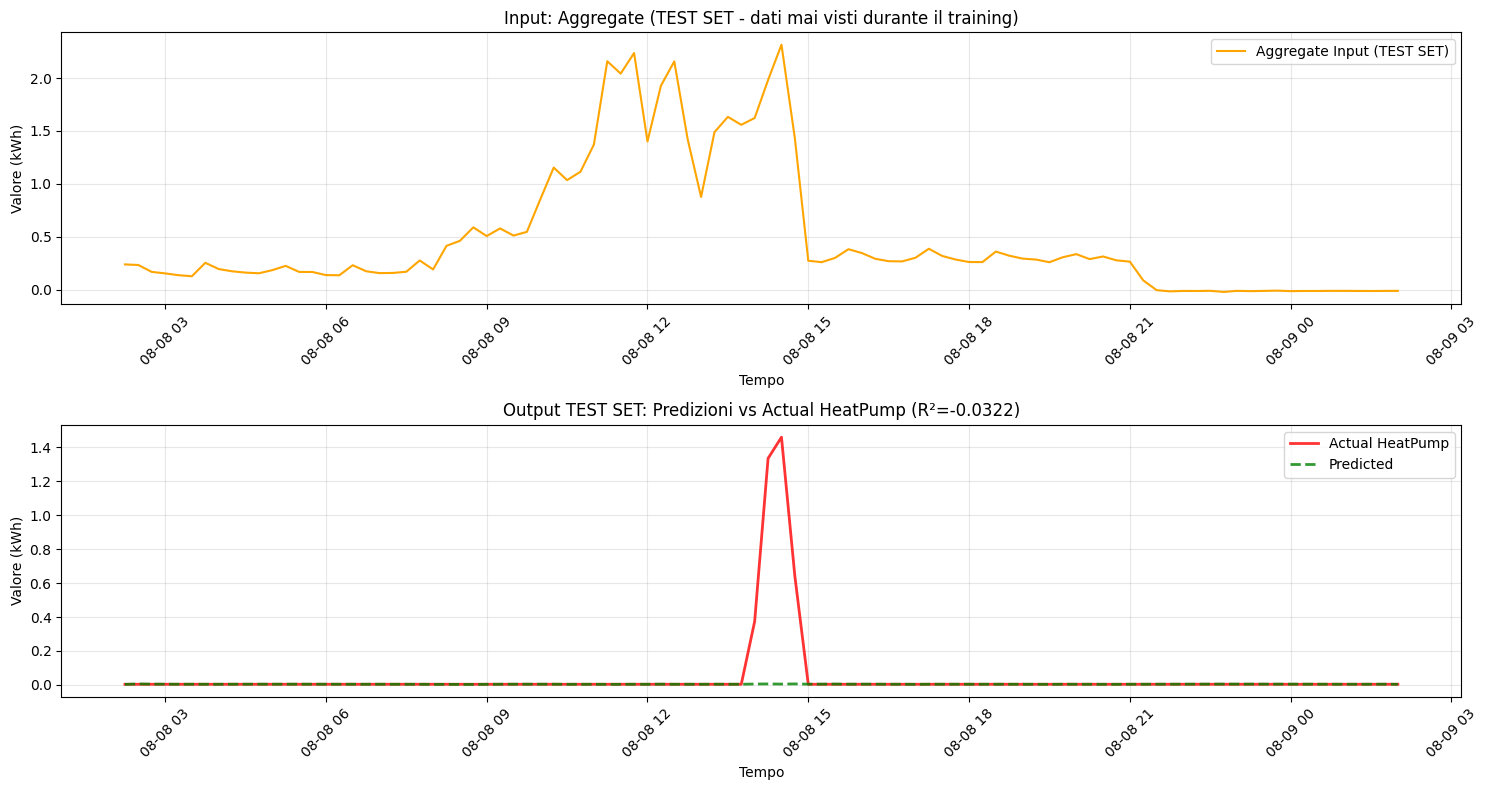

In [36]:
# Visualizza predizioni vs actual del TEST SET (denormalizzati)
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# Input usato (denormalizzato)
input_denorm = input_scaler.inverse_transform(seq_building_test[test_idx]).flatten()

# Calcola l'indice temporale reale (offset dal split point)
real_idx = split_idx + timestamps_test[test_idx]
time_axis = Building['_time'].iloc[real_idx:real_idx+window_size].values

axes[0].plot(time_axis, input_denorm, linewidth=1.5, color='orange', label='Aggregate Input (TEST SET)')
axes[0].set_title('Input: Aggregate (TEST SET - dati mai visti durante il training)')
axes[0].set_xlabel('Tempo')
axes[0].set_ylabel('Valore (kWh)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Output predetto vs actual
axes[1].plot(time_axis, actual, linewidth=2, label=f'Actual {TARGET_APPLIANCE}', color='red', alpha=0.8)
axes[1].plot(time_axis, predictions, linewidth=2, label='Predicted', color='green', linestyle='--', alpha=0.8)
axes[1].set_title(f'Output TEST SET: Predizioni vs Actual {TARGET_APPLIANCE} (R²={r2:.4f})')
axes[1].set_xlabel('Tempo')
axes[1].set_ylabel('Valore (kWh)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [19]:
# Test su più sequenze del TEST SET per valutazione più robusta
print("📊 Valutazione su TEST SET (dati mai visti durante il training!):")
print(f"   Numero totale sequenze di test: {len(seq_building_test)}\n")

# Testa su diverse sequenze del test set
num_test_samples = min(50, len(seq_building_test))
test_indices = np.linspace(0, len(seq_building_test)-1, num_test_samples, dtype=int)
all_mse, all_mae, all_r2 = [], [], []

model.eval()
with torch.no_grad():
    for idx in test_indices:
        inp = torch.FloatTensor(seq_building_test[idx]).unsqueeze(0).to(device)
        tgt = torch.FloatTensor(seq_oven_test[idx]).unsqueeze(0).to(device)
        
        pred = model(inp).cpu().numpy().squeeze()
        act = tgt.cpu().numpy().squeeze()
        
        # Denormalizza
        pred_denorm = target_scaler.inverse_transform(pred.reshape(-1, 1)).flatten()
        act_denorm = target_scaler.inverse_transform(act.reshape(-1, 1)).flatten()
        
        all_mse.append(mean_squared_error(act_denorm, pred_denorm))
        all_mae.append(mean_absolute_error(act_denorm, pred_denorm))
        all_r2.append(r2_score(act_denorm, pred_denorm))

print(f"📊 Risultati su {num_test_samples} sequenze del TEST SET:")
print(f"  Media MSE: {np.mean(all_mse):.6f} ± {np.std(all_mse):.6f}")
print(f"  Media MAE: {np.mean(all_mae):.6f} ± {np.std(all_mae):.6f}")
print(f"  Media R²:  {np.mean(all_r2):.4f} ± {np.std(all_r2):.4f}")
print(f"\n✅ Questi risultati sono AFFIDABILI perché calcolati su dati MAI visti!")

📊 Valutazione su TEST SET (dati mai visti durante il training!):
   Numero totale sequenze di test: 6912

📊 Risultati su 50 sequenze del TEST SET:
  Media MSE: 0.084484 ± 0.073231
  Media MAE: 0.085396 ± 0.075653
  Media R²:  -28853540.4317 ± 152039925.8740

✅ Questi risultati sono AFFIDABILI perché calcolati su dati MAI visti!
